<a href="https://colab.research.google.com/github/CS4641-2021/sports-numbers-fans/blob/main/FantasyFootballRecommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall yellowbrick -y

!pip install -U yellowbrick==1.2

Found existing installation: yellowbrick 0.9.1
Uninstalling yellowbrick-0.9.1:
  Successfully uninstalled yellowbrick-0.9.1
     |████████████████████████████████| 269 kB 27.6 MB/s 


In [ ]:
!pip uninstall scikit-learn -y

!pip install -U scikit-learn==0.23.2

Found existing installation: scikit-learn 0.22.2.post1
Uninstalling scikit-learn-0.22.2.post1:
  Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 6.8 MB 31.8 MB/s 


In [ ]:
from google.colab import files
data = files.upload()

In [ ]:
import pandas as pd
import yellowbrick
from yellowbrick.features import Rank2D, ParallelCoordinates
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_validate

In [ ]:
#Create dataframe of 2018 stats
df1 = pd.read_csv('2018_season_stats.csv')
df1 = df1.drop(columns="Position")
df2 = pd.read_csv('2018_advanced.csv')
df2 = df2.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df2 = df2.rename(columns={"PlayerPlayerId" : "PlayerID"})
df3 = pd.read_csv('2018_efficiency.csv')
df3 = df3.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df3 = df3.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2018 = df1.join(df2.set_index("PlayerID"), on="PlayerID")
df2018 = df2018.join(df3.set_index("PlayerID"), on="PlayerID")

#create dataframe of 2019 stats
df4 = pd.read_csv('2019_season_stats.csv')
df4 = df4.drop(columns="Position")
df5 = pd.read_csv('2019_advanced.csv')
df5 = df5.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df5 = df5.rename(columns={"PlayerPlayerId" : "PlayerID"})
df6 = pd.read_csv('2019_efficiency.csv')
df6 = df6.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df6 = df6.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2019 = df4.join(df5.set_index("PlayerID"), on="PlayerID")
df2019 = df2019.join(df6.set_index("PlayerID"), on="PlayerID")

#create dataframe of 2017 stats
df7 = pd.read_csv('2017_season_stats.csv')
df7 = df7.drop(columns="Position")
df8 = pd.read_csv('2017_advanced_stats.csv')
df8 = df8.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards","Targets.1"])
df8 = df8.rename(columns={"PlayerPlayerId" : "PlayerID"})
df9 = pd.read_csv('2017_efficiency_stats.csv')
df9 = df9.drop(columns=["Rank","PlayerShortName","Targets","Receptions","ReceivingTDs","ReceivingYards"])
df9 = df9.rename(columns={"PlayerPlayerId" : "PlayerID"})
df2017 = df7.join(df8.set_index("PlayerID"), on="PlayerID")
df2017 = df2017.join(df9.set_index("PlayerID"), on="PlayerID")

#Create results dataframe for following years
df2018results = df1[["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"]]
df2019results = df4[["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"]]
df2020results = pd.read_csv('2020_season_stats.csv', usecols=["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"])
df2020_expert_prediction = pd.read_csv('2020_expert_prediction.csv', usecols=["PlayerID","FantasyPointsPPR","FantasyPointsPerGamePPR"])


#Adding next year results to season stats
df2017 = df2017.join(df2018results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")
df2018 = df2018.join(df2019results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")
df2019 = df2019.join(df2020results.set_index("PlayerID"), rsuffix="_NextYear", on="PlayerID")


# save the origial missing values datasets (before dropping NA values)
df2017_orig = df2017
df2018_orig = df2018
df2019_orig = df2019

#Removing features that either dont exist for some dataset or are irrelivant, then removing incomplete data 
df2017 = df2017.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()
df2018 = df2018.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()
df2019 = df2019.drop(columns=['Name','Team','AirYards','AirYardsPerGame','AirYardsPerReception', 'TrueCatchRate', 'TargetAccuracy', 'Cushion']).dropna()

#Classify scores into some number of bins
num_bins = 4
target_df2017_max = df2017["FantasyPointsPerGamePPR_NextYear"].max()
target_df2017_min = df2017["FantasyPointsPerGamePPR_NextYear"].min()
target_df2017_bin_width = (target_df2017_max - target_df2017_min)/num_bins
df2017["ScoreTier_NextYear"] = -1*((df2017["FantasyPointsPerGamePPR_NextYear"] - target_df2017_min) // (-1*target_df2017_bin_width))
df2017["ScoreTier_NextYear"] = df2017["ScoreTier_NextYear"].replace(0,1)

target_df2018_max = df2018["FantasyPointsPerGamePPR_NextYear"].max()
target_df2018_min = df2018["FantasyPointsPerGamePPR_NextYear"].min()
target_df2018_bin_width = (target_df2018_max - target_df2018_min)/num_bins
df2018["ScoreTier_NextYear"] = -1*((df2018["FantasyPointsPerGamePPR_NextYear"] - target_df2018_min) // (-1*target_df2018_bin_width))
df2018["ScoreTier_NextYear"] = df2018["ScoreTier_NextYear"].replace(0,1)

target_df2019_max = df2019["FantasyPointsPerGamePPR_NextYear"].max()
target_df2019_min = df2019["FantasyPointsPerGamePPR_NextYear"].min()
target_df2019_bin_width = (target_df2019_max - target_df2019_min)/num_bins
df2019["ScoreTier_NextYear"] = -1*((df2019["FantasyPointsPerGamePPR_NextYear"] - target_df2019_min) // (-1*target_df2019_bin_width))
df2019["ScoreTier_NextYear"] = df2019["ScoreTier_NextYear"].replace(0,1)

df1718 = pd.concat([df2017,df2018],ignore_index=True)

#Get expert predictions for players that are in our testing data and sort predictions by playerID
expert_prediction = df2020_expert_prediction[df2020_expert_prediction["PlayerID"].isin(df2019["PlayerID"])].sort_values(by=['PlayerID'])
expert_prediction.reset_index(inplace=True, drop=True)



In [ ]:
def normalizeDF(df, exclude_columns=[]):
  result = df.copy()
  for feature_name in df.columns:
    if feature_name in exclude_columns:
      continue
    max_value = df[feature_name].max()
    min_value = df[feature_name].min()
    result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
  return result

def normalizeSeries(series):
  result = series.copy()
  max_value = series.max()
  min_value = series.min()
  result = (series - min_value) / (max_value - min_value)
  return result

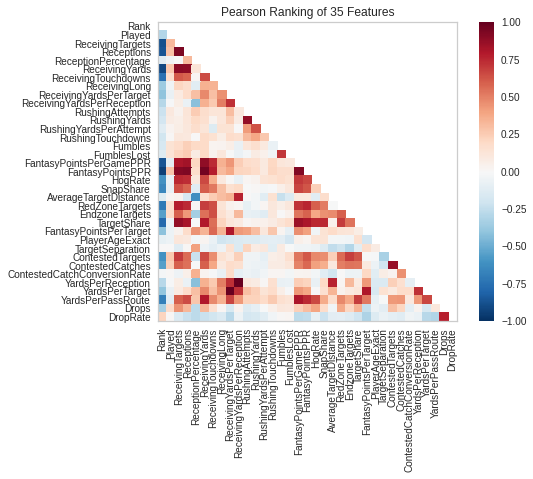

In [ ]:
visualizer = Rank2D(algorithm = "pearson")
visualizer.fit_transform(normalizeDF(df1718.drop(["PlayerID", "FantasyPointsPPR_NextYear", "FantasyPointsPerGamePPR_NextYear", "ScoreTier_NextYear"],axis=1)))
visualizer.show()


Parallel Coordinates

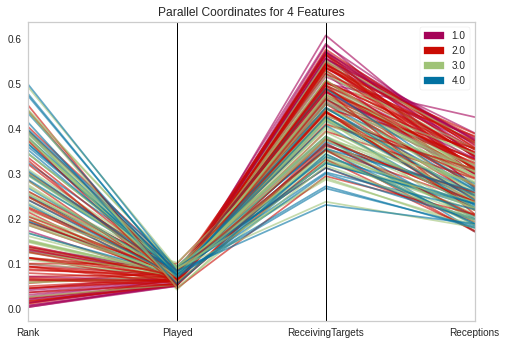

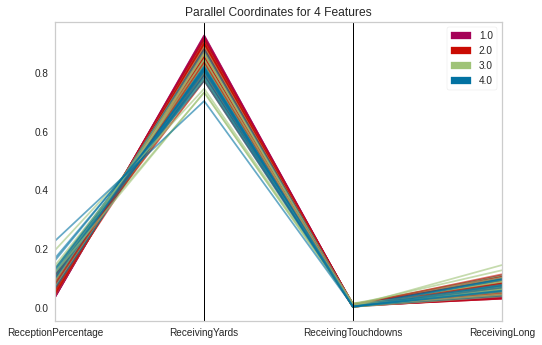

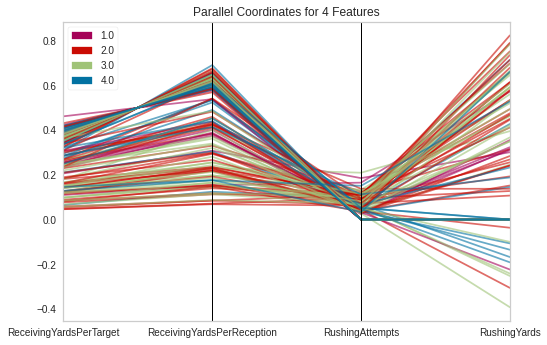

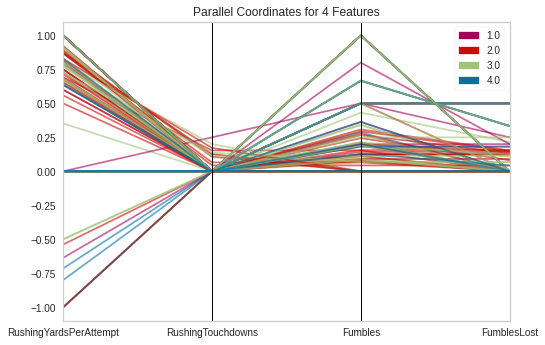

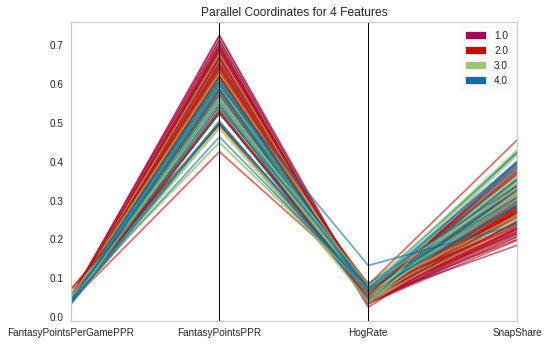

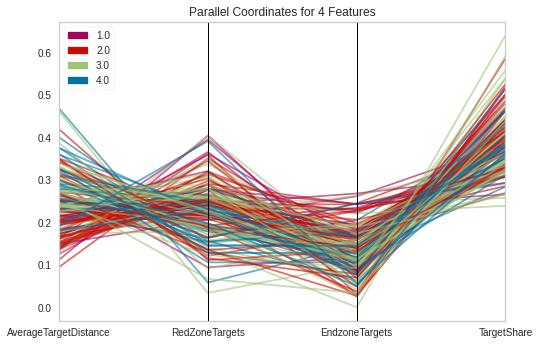

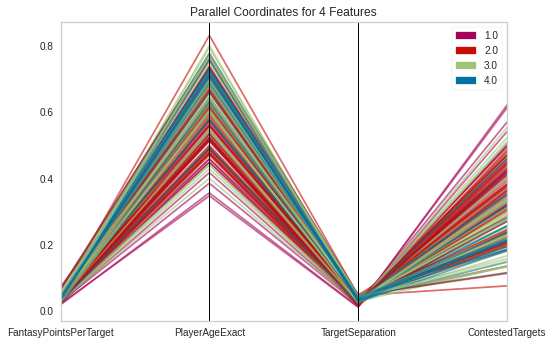

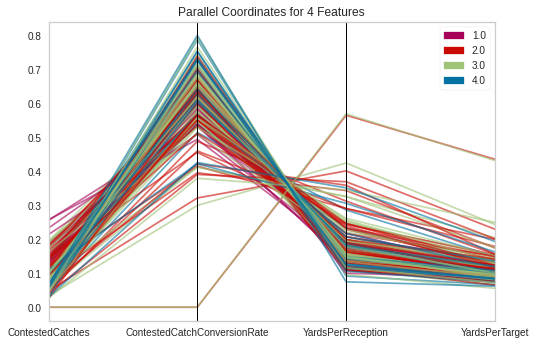

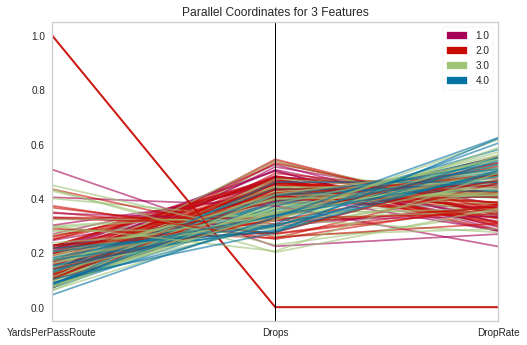

In [ ]:
features = df1718.drop(columns=["FantasyPointsPPR_NextYear", "ScoreTier_NextYear", "PlayerID", "FantasyPointsPerGamePPR_NextYear"]).columns
classes = df1718["ScoreTier_NextYear"].unique()
#splitting the classes into bite size chunks to make visualization easier
split_features = np.array_split(features, 9)
for feature_set in split_features:
  visualizer = visualizer = ParallelCoordinates(
      classes=classes, features=feature_set,
      normalize='l1', alpha=.6
  )
  visualizer.fit(df1718[feature_set], df1718["ScoreTier_NextYear"])     
  visualizer.transform(df1718[feature_set])   
  visualizer.poof()

Distribution of target variable

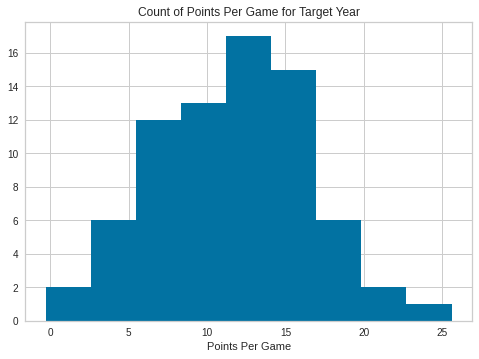

In [ ]:
results = df2019["FantasyPointsPerGamePPR_NextYear"]
_ = plt.hist(results, bins='auto')
plt.title("Count of Points Per Game for Target Year")
plt.xlabel("Points Per Game")
plt.show()


Model Predictions

Score for Bayesian Ridge model (standard): 0.2810
Score for Bayesian Ridge model using cross validation (standard): 0.3280
RMSE for Bayesing Ridge model using cross validation (standard): 4.11
Score for Bayesian Ridge model (normalized): 0.4269
Score for Bayesian Ridge model using cross validation (normalized): 0.4176
RMSE for Bayesing Ridge model using cross validation (normalized): 3.82


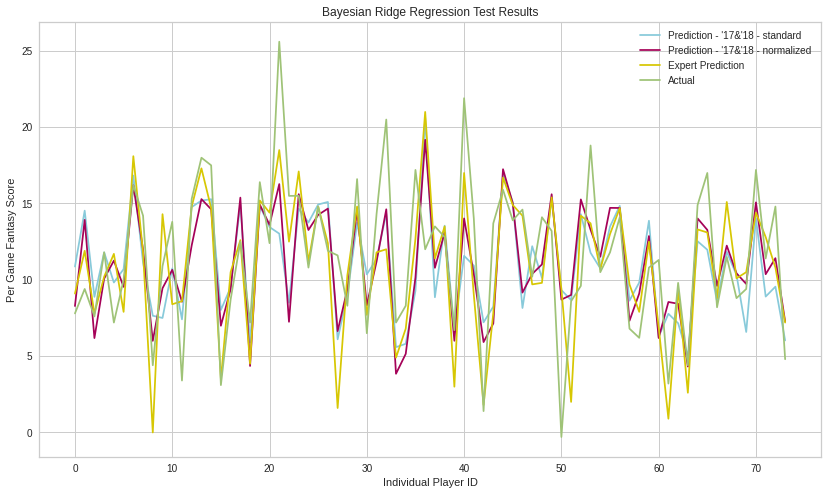

In [ ]:
#Non normalized training set
train_x_1 = df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"])
train_y_1 = df1718["FantasyPointsPerGamePPR_NextYear"]

#Normalized training set
train_x_2 = normalizeDF(df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"]))
train_y_2 = df1718["FantasyPointsPerGamePPR_NextYear"]

#Create the testing set, which is sorted by playerID containing the same elements as expert_prediction, in order 
#Testing data sorted by playerID (actual data does not contain the playerID, though)
test_x_1 = df2019.sort_values(by=["PlayerID"]).drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"])
test_x_2 = normalizeDF(test_x_1)
test_y = df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR_NextYear"]

test_x_1.reset_index(inplace=True, drop=True)
test_x_2.reset_index(inplace=True, drop=True)
test_y.reset_index(inplace=True, drop=True)

#Combine datasets for cross-validation
X_1 = pd.concat([train_x_1, test_x_1])
X_2 = pd.concat([train_x_2, test_x_2])
y = pd.concat([train_y_1, test_y])

#Normal ridge regression for standard data
clf = BayesianRidge()

clf.fit(train_x_1, train_y_1)
p_1 = clf.predict(test_x_1)

print("Score for Bayesian Ridge model (standard):", f'{clf.score(test_x_1, test_y):,.4f}')
cv_clf_1 = cross_validate(clf, X_1, y, cv = 5, scoring = ('r2', 'neg_root_mean_squared_error'))
cv_clf_1_score = cv_clf_1['test_r2'].mean()
print("Score for Bayesian Ridge model using cross validation (standard):", f'{cv_clf_1_score:,.4f}')
clf_RMSE_1 = -1*cv_clf_1['test_neg_root_mean_squared_error'].mean()
print("RMSE for Bayesing Ridge model using cross validation (standard):", f'{clf_RMSE_1:,.2f}')

clf.fit(train_x_2, train_y_2)
p_2 = clf.predict(test_x_2)

print("Score for Bayesian Ridge model (normalized):", f'{clf.score(test_x_2, test_y):,.4f}')
cv_clf_2 = cross_validate(clf, X_2, y, cv = 5, scoring = ('r2', 'neg_root_mean_squared_error'))
cv_clf_2_score = cv_clf_2['test_r2'].mean()
print("Score for Bayesian Ridge model using cross validation (normalized):", f'{cv_clf_2_score:,.4f}')
clf_RMSE_2 = -1*cv_clf_2['test_neg_root_mean_squared_error'].mean()
print("RMSE for Bayesing Ridge model using cross validation (normalized):", f'{clf_RMSE_2:,.2f}')


plt.figure(figsize=(14,8))
#plt.plot(test_x.index, df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR"], 'C6', label='Last Year Performance') 
plt.plot(test_x_1.index, p_1, 'C5', label='Prediction - \'17&\'18 - standard') 
plt.plot(test_x_1.index, p_2, 'C3', label='Prediction - \'17&\'18 - normalized') 
plt.plot(test_x_1.index, expert_prediction["FantasyPointsPerGamePPR"], 'C4', label='Expert Prediction') 
plt.plot(test_x_1.index, test_y, 'C1', label="Actual")


plt.xlabel("Individual Player ID")
plt.ylabel("Per Game Fantasy Score")
plt.title("Bayesian Ridge Regression Test Results")
plt.legend()

Calculate RMSE for BayseanRidge

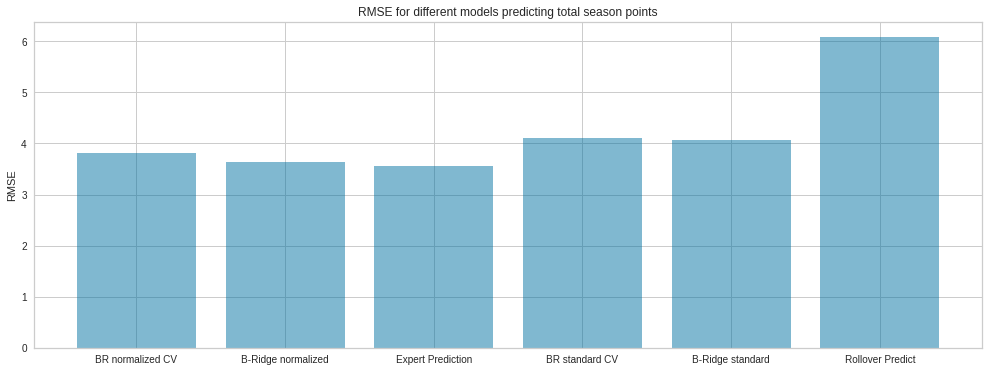

RMSE - Expert Prediction:	 3.56
RMSE - B-Ridge normalized:	 3.64
RMSE - BR normalized CV:	 3.82
RMSE - B-Ridge standard:	 4.07
RMSE - BR standard CV:		 4.11
RMSE - Rollover Predict:	 6.08


In [ ]:
models = ["BR normalized CV", "B-Ridge normalized", 'Expert Prediction', "BR standard CV","B-Ridge standard", "Rollover Predict"]
pos = np.arange(len(models))
performance = np.zeros(len(models))

performance[0] = clf_RMSE_2
performance[1] = np.sqrt(np.mean((p_2-test_y)**2))
performance[2] = np.sqrt(np.mean((expert_prediction['FantasyPointsPerGamePPR']-test_y)**2))
performance[3] = clf_RMSE_1
performance[4] = np.sqrt(np.mean((p_1-test_y)**2))
performance[5] = np.sqrt(np.mean(((df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR"])-test_y)**2))


plt.subplots(figsize = (17, 6))
plt.bar(pos, performance, align='center', alpha=0.5)
plt.xticks(pos, models)
plt.ylabel('RMSE')
plt.title('RMSE for different models predicting total season points')
plt.show()

print('RMSE - Expert Prediction:\t', f'{performance[2]:,.2f}')
expert_rmse_cache = performance[2]
print("RMSE - B-Ridge normalized:\t", f'{performance[1]:,.2f}')
print("RMSE - BR normalized CV:\t", f'{performance[0]:,.2f}')
print("RMSE - B-Ridge standard:\t", f'{performance[4]:,.2f}')
print("RMSE - BR standard CV:\t\t", f'{performance[3]:,.2f}')
print("RMSE - Rollover Predict:\t", f'{performance[5]:,.2f}')

#Linear Regression



In [ ]:
from yellowbrick.regressor import ResidualsPlot
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split






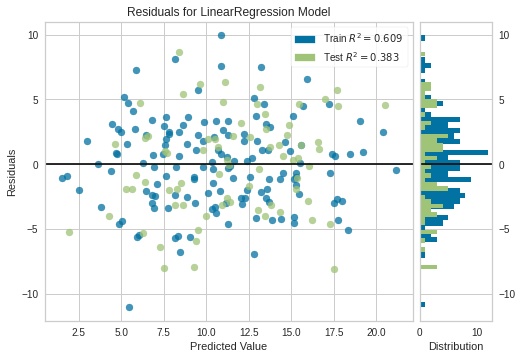

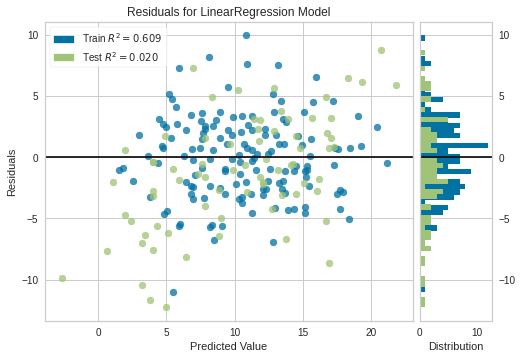

In [ ]:
# Create training and test sets
#X_train, X_test, y_train, y_test = train_test_split(
#    X, y, test_size=0.1
#)
## df1718 dataset
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(train_x_1, train_y_1)
visualizer.score(test_x_1, test_y)
visualizer.show()

##df2019 dataset
visualizer = ResidualsPlot(LinearRegression())
visualizer.fit(train_x_2, train_y_2)
visualizer.score(test_x_2, test_y)
visualizer.show()


# KMeans Clustering
From https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


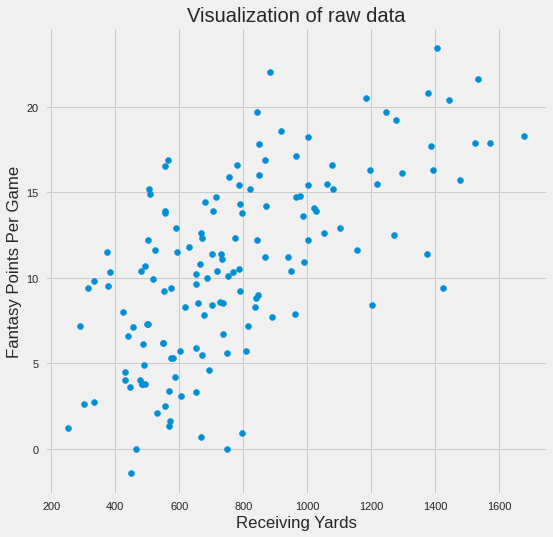

In [ ]:
# Plot the raw data df1718
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

# Import the data
#df1718.head()
df = df1718[['ReceivingYards', 'FantasyPointsPerGamePPR_NextYear']]
#df.head()
#df1718.iloc[:,6]
#df1718.iloc[:,-2]
# Plot the data
plt.figure(figsize=(8, 8))
#plt.scatter(df1718.iloc[:, 6], df1718.iloc[:, -2])
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of raw data');

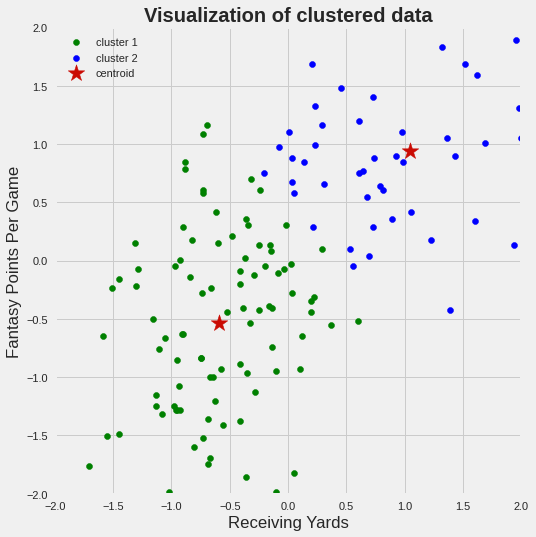

In [ ]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = KMeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.cluster_centers_

# Plot the clustered data
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Receiving Yards')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

Elbow Method

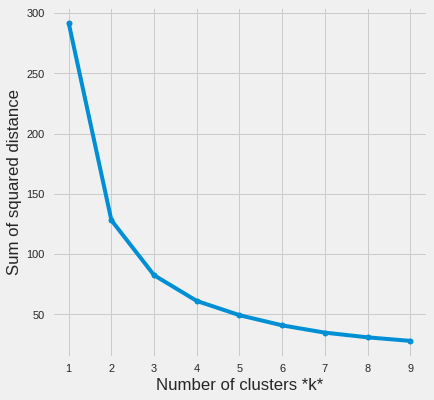

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

Silhouette Analysis


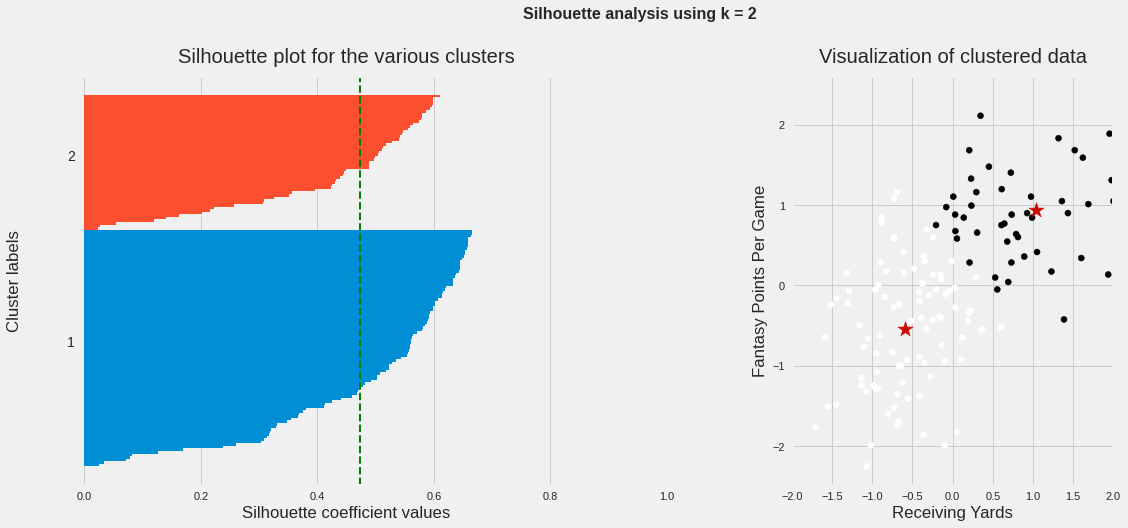

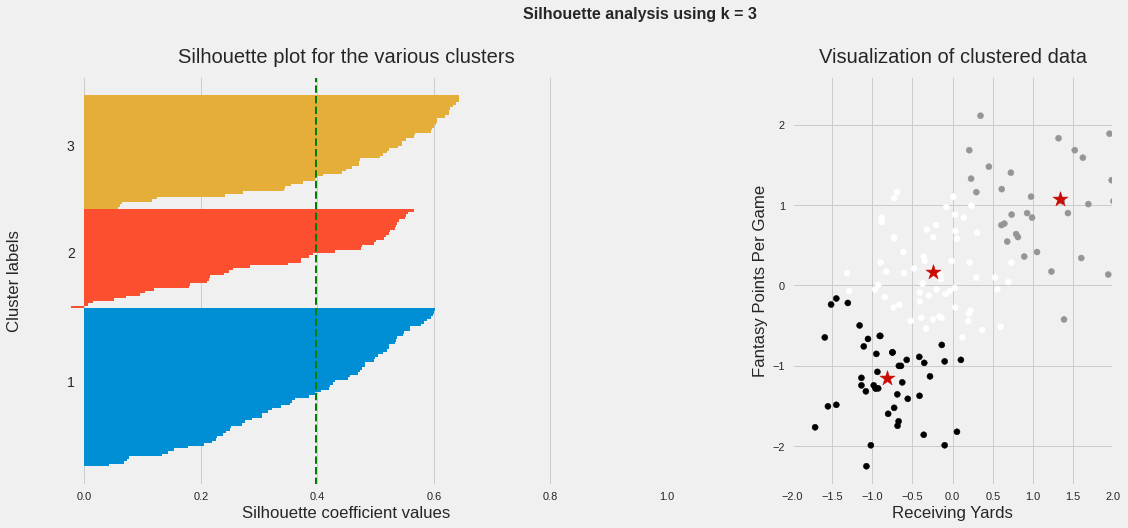

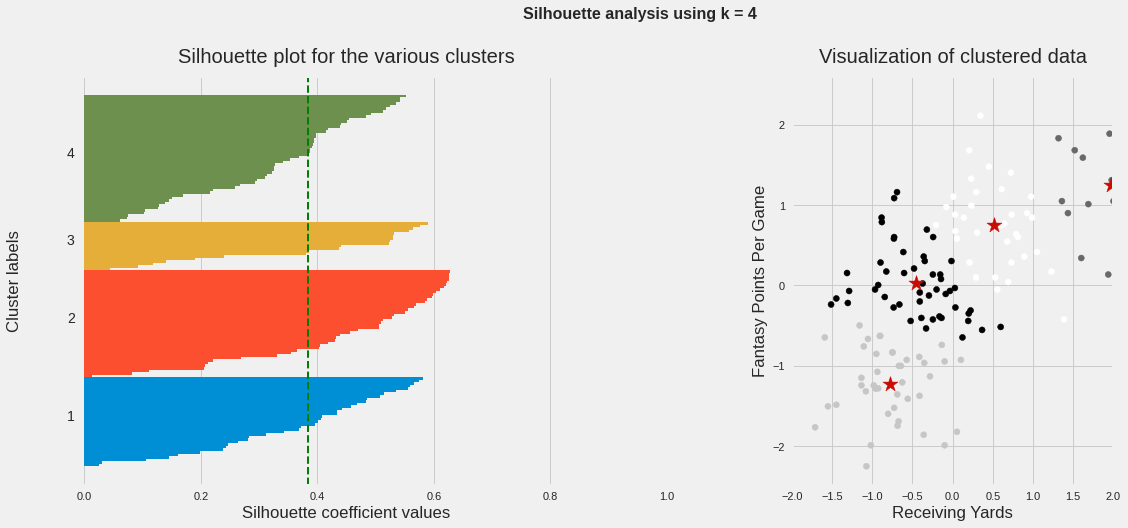

In [ ]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Receiving Yards')
    ax2.set_ylabel('Fantasy Points Per Game')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

## **Comparing Different Regressors**


In [ ]:
!pip install sklearn.ensemble

ERROR: Could not find a version that satisfies the requirement sklearn.ensemble (from versions: none)
ERROR: No matching distribution found for sklearn.ensemble


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

X_train = normalizeDF(df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"]))
X_test = normalizeDF(df2019.sort_values(by=["PlayerID"]).drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"]))
y_train = df1718["FantasyPointsPerGamePPR_NextYear"]
y_test = df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR_NextYear"]

X_test.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

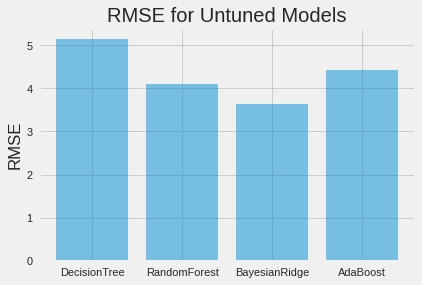

RMSE - Decision Tree:	 5.15
RMSE - Random Forest:	 4.09
RMSE - Bayesian Ridge:	 3.64
RMSE - AdaBoost:	 4.43


In [ ]:
models = ["DecisionTree", "RandomForest", "BayesianRidge", "AdaBoost"]
performance = []
pos = np.arange(len(models))

regr_1 = DecisionTreeRegressor()
regr_2 = RandomForestRegressor()
regr_3 = BayesianRidge()
regr_4 = AdaBoostRegressor()
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)
regr_3.fit(X_train, y_train)
regr_4.fit(X_train, y_train)

p1, p2, p3, p4 = regr_1.predict(X_test), regr_2.predict(X_test), regr_3.predict(X_test), regr_4.predict(X_test)


performance.append(np.sqrt(np.mean((p1-test_y)**2)))
performance.append(np.sqrt(np.mean((p2-test_y)**2)))
performance.append(np.sqrt(np.mean((p3-test_y)**2)))
performance.append(np.sqrt(np.mean((p4-test_y)**2)))

plt.bar(pos, performance, align='center', alpha=0.5)
plt.xticks(pos, models)
plt.ylabel('RMSE')
plt.title('RMSE for Untuned Models')
plt.show()

print('RMSE - Decision Tree:\t', f'{performance[0]:,.2f}')
print("RMSE - Random Forest:\t", f'{performance[1]:,.2f}')
print("RMSE - Bayesian Ridge:\t", f'{performance[2]:,.2f}')
print("RMSE - AdaBoost:\t", f'{performance[3]:,.2f}')


Hyperparamater tuning with grid search


In [ ]:
from sklearn.model_selection import GridSearchCV

models = ["DecisionTree", "RandomForest", "BayesianRidge", "AdaDTree", "AdaRForest", "AdaBRidge"]
pos = np.arange(len(models))

dtree_params = {'max_depth':[10,7,4,3], 'min_samples_split':[2,4,6], 'max_features':['auto', 'sqrt', 'log2'], 'min_impurity_decrease':[0.0, 0.05, 0.1, 0.15]}
rforest_params = {'n_estimators':[30], 'max_depth':[10,7,4,3], 'min_samples_split':[2,4,6], 'max_features':['auto', 'sqrt', 'log2'], 'min_impurity_decrease':[0.0, 0.05, 0.1, 0.15]}
bridge_params = {'alpha_1':[1e-06, 1e-04, 1e-02, 1e-01], 'alpha_2':[1e-06, 1e-04, 1e-02, 1e-01], 'lambda_1':[1e-06, 1e-04, 1e-02, 1e-01], 'lambda_2':[1e-06, 1e-04, 1e-02, 1e-01]}
aboost_params = {'n_estimators':[50], 'learning_rate':[0.01, 0.1, 0.5, 1.0], 'loss':['linear', 'square', 'exponential']}


regr_1 = GridSearchCV(DecisionTreeRegressor(), dtree_params)
regr_2 = GridSearchCV(RandomForestRegressor(), rforest_params)
regr_3 = GridSearchCV(BayesianRidge(), bridge_params)


In [ ]:
regr_1.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [10, 7, 4, 3],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_impurity_decrease': [0.0, 0.05, 0.1, 0.15],
                         'min_samples_split': [2, 4, 6]})

In [ ]:
regr_2.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
regr_3.fit(X_train, y_train)

In [ ]:
regr_4 = GridSearchCV(AdaBoostRegressor(base_estimator=regr_1.best_estimator_), aboost_params)
regr_5 = GridSearchCV(AdaBoostRegressor(base_estimator=regr_2.best_estimator_), aboost_params)
regr_6 = GridSearchCV(AdaBoostRegressor(base_estimator=regr_3.best_estimator_), aboost_params)

In [ ]:
  regr_4.fit(X_train, y_train)

In [ ]:
regr_5.fit(X_train, y_train)

In [ ]:
regr_6.fit(X_train, y_train)

In [ ]:
p1, p2, p3, p4, p5, p6 = regr_1.predict(X_test), regr_2.predict(X_test), regr_3.predict(X_test), regr_4.predict(X_test), regr_5.predict(X_test), regr_6.predict(X_test)

new_performance = []
new_performance.append(np.sqrt(np.mean((p1-test_y)**2)))
new_performance.append(np.sqrt(np.mean((p2-test_y)**2)))
new_performance.append(np.sqrt(np.mean((p3-test_y)**2)))
new_performance.append(np.sqrt(np.mean((p4-test_y)**2)))
new_performance.append(np.sqrt(np.mean((p5-test_y)**2)))
new_performance.append(np.sqrt(np.mean((p6-test_y)**2)))



plt.subplots(figsize = (17, 6))
plt.bar(pos, new_performance, align='center', alpha=0.5)
plt.xticks(pos, models)
plt.ylabel('RMSE')
plt.title('RMSE for Tuned Models')
plt.show()

print('RMSE - Tuned Decision Tree:\t\t', f'{new_performance[0]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[0]-new_performance[0]:,.2f}')
print("RMSE - Tuned Random Forest:\t\t", f'{new_performance[1]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[1]-new_performance[1]:,.2f}')
print("RMSE - Tuned Bayesian Ridge:\t\t", f'{new_performance[2]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[2]-new_performance[2]:,.2f}')
print("RMSE - Tuned AdaBoost / DTree:\t\t", f'{new_performance[3]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[0]-new_performance[3]:,.2f}')
print("RMSE - Tuned AdaBoost / RForest:\t", f'{new_performance[4]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[1]-new_performance[4]:,.2f}')
print("RMSE - Tuned AdaBoost / BRidge:\t\t", f'{new_performance[5]:,.2f}', "\tReduction in RMSE from tuning:\t", f'{performance[2]-new_performance[5]:,.2f}')

# Feature Selection

In [ ]:
import pandas as pd
import statsmodels.formula.api as sm
import statsmodels.api as sm

class FeatureSelection(object):
    def __init__(self):
        pass

    @staticmethod
    def forward_selection(data, target_column, significance_level=0.05): 
        '''
        Args:
            data: data frame that contains the feature matrix
            target: target feature to search to generate significant features
            significance_level: the probability of the event occuring by chance
        Return:
            forward_list: list containing significant features (in order of selection)

        '''
        #raise NotImplementedError
        cols = list(data.columns)
        pmax = 1
        while (len(cols)>0):
            p = []
            df_1 = data[cols]
            df_1 = sm.add_constant(df_1)
            model = sm.OLS(data[target_column], df_1).fit()
            p = pd.Series(model.pvalues.values[1:], index = cols)
            maxp = max(p)
            feat_maxp = p.idxmax()
            if (maxp > significance_level):
                cols.remove(feat_maxp)
            else:
                break
        return cols

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df1718.head()

,Rank,PlayerID,Played,ReceivingTargets,Receptions,ReceptionPercentage,ReceivingYards,ReceivingTouchdowns,ReceivingLong,ReceivingYardsPerTarget,ReceivingYardsPerReception,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,Fumbles,FumblesLost,FantasyPointsPerGamePPR,FantasyPointsPPR,HogRate,SnapShare,AverageTargetDistance,RedZoneTargets,EndzoneTargets,TargetShare,FantasyPointsPerTarget,PlayerAgeExact,TargetSeparation,ContestedTargets,ContestedCatches,ContestedCatchConversionRate,YardsPerReception,YardsPerTarget,YardsPerPassRoute,Drops,DropRate,FantasyPointsPPR_NextYear,FantasyPointsPerGamePPR_NextYear,ScoreTier_NextYear
0,1,11056,14,163,101,62.0,1533,9,57,9.4,15.2,0,0,0.0,0,4,0,22.2,310.30,19.3,92.0,13.7,21.0,14.0,30.7,1.90,33.0,1.67,31.0,20.0,64.5,15.2,9.5,2.98,5.0,3.1,323.70,21.6,4.0
1,2,14986,15,174,96,55.2,1378,13,72,7.9,14.4,0,0,0.0,0,1,1,20.7,309.80,18.1,100.0,13.7,19.0,24.0,35.2,1.79,29.1,0.96,52.0,23.0,44.2,14.4,7.9,2.54,6.0,3.4,333.50,20.8,4.0
2,3,15076,16,159,102,64.2,1393,6,51,8.8,13.7,2,9,4.5,1,1,0,17.8,284.20,19.9,79.9,9.4,24.0,14.0,27.7,1.79,29.2,1.39,24.0,10.0,41.7,13.7,8.8,2.77,12.0,7.5,260.10,16.3,3.0
3,4,5571,16,161,109,67.7,1156,6,37,7.2,10.6,0,0,0.0,0,1,1,16.3,261.44,15.9,100.0,8.7,20.0,7.0,27.2,1.62,37.9,1.52,22.0,13.0,59.1,10.6,7.2,1.87,4.0,2.5,185.68,11.6,3.0
4,5,16020,16,161,112,69.6,987,9,49,6.1,8.8,1,-7,-7.0,0,4,2,16.2,260.00,17.8,93.8,6.2,23.0,9.0,27.4,1.63,28.6,1.42,23.0,9.0,39.1,8.8,6.1,1.70,8.0,5.0,217.12,13.6,3.0


In [ ]:
X = df1718.drop(columns=["Rank",  "FantasyPointsPPR_NextYear", "ScoreTier_NextYear", "PlayerID"])
y = 'FantasyPointsPerGamePPR_NextYear'
featureselection = FeatureSelection()
print("Features selected by forward selection:", featureselection.forward_selection(X, y))

Features selected by forward selection: ['RushingYards', 'FantasyPointsPerGamePPR_NextYear']


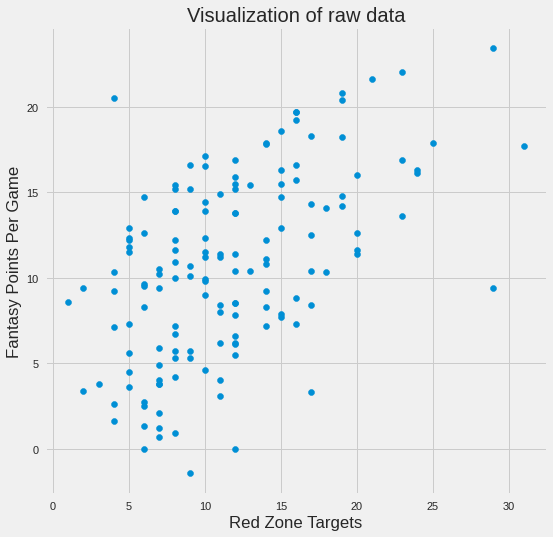

In [ ]:
# Plot the raw data df1718
import matplotlib.pyplot as plt
from matplotlib.image import imread
import pandas as pd
import seaborn as sns
from sklearn.datasets.samples_generator import (make_blobs,
                                                make_circles,
                                                make_moons)
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score

%matplotlib inline
sns.set_context('notebook')
plt.style.use('fivethirtyeight')
from warnings import filterwarnings
filterwarnings('ignore')

# Import the data
#df1718.head()
df = df1718[['RedZoneTargets', 'FantasyPointsPerGamePPR_NextYear']]
#df.head()
#df1718.iloc[:,6]
#df1718.iloc[:,-2]
# Plot the data
plt.figure(figsize=(8, 8))
#plt.scatter(df1718.iloc[:, 6], df1718.iloc[:, -2])
plt.scatter(df.iloc[:,0], df.iloc[:,1])
plt.xlabel('Red Zone Targets')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of raw data');

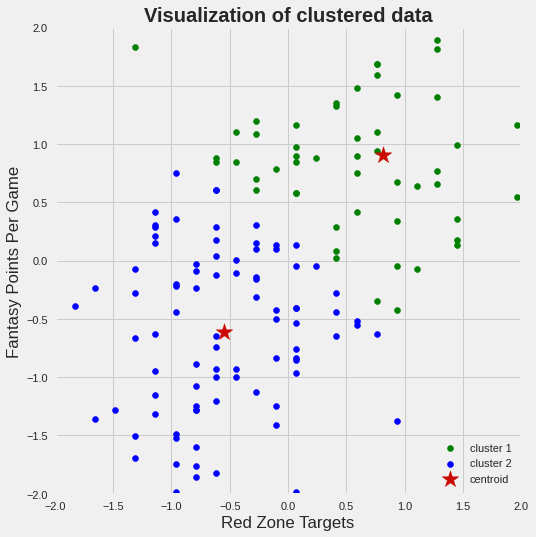

In [ ]:
# Standardize the data
X_std = StandardScaler().fit_transform(df)

# Run local implementation of kmeans
km = KMeans(n_clusters=2, max_iter=100)
km.fit(X_std)
centroids = km.cluster_centers_

# Plot the clustered data
fig, ax = plt.subplots(figsize=(8, 8))
plt.scatter(X_std[km.labels_ == 0, 0], X_std[km.labels_ == 0, 1],
            c='green', label='cluster 1')
plt.scatter(X_std[km.labels_ == 1, 0], X_std[km.labels_ == 1, 1],
            c='blue', label='cluster 2')
plt.scatter(centroids[:, 0], centroids[:, 1], marker='*', s=300,
            c='r', label='centroid')
plt.legend()
plt.xlim([-2, 2])
plt.ylim([-2, 2])
plt.xlabel('Red Zone Targets')
plt.ylabel('Fantasy Points Per Game')
plt.title('Visualization of clustered data', fontweight='bold')
ax.set_aspect('equal');

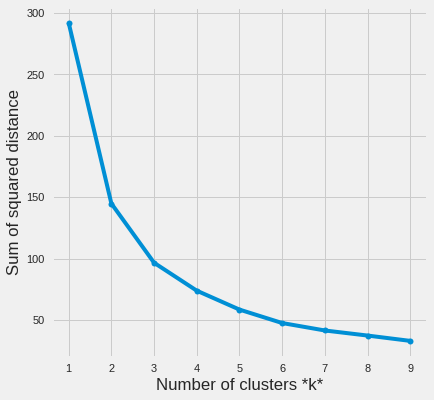

In [ ]:
# Run the Kmeans algorithm and get the index of data points clusters
sse = []
list_k = list(range(1, 10))

for k in list_k:
    km = KMeans(n_clusters=k)
    km.fit(X_std)
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

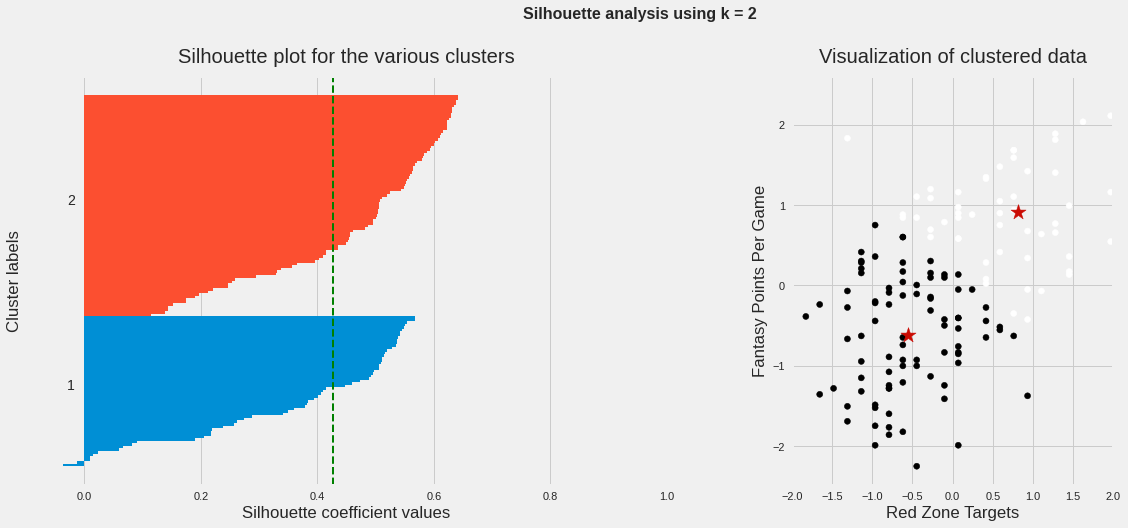

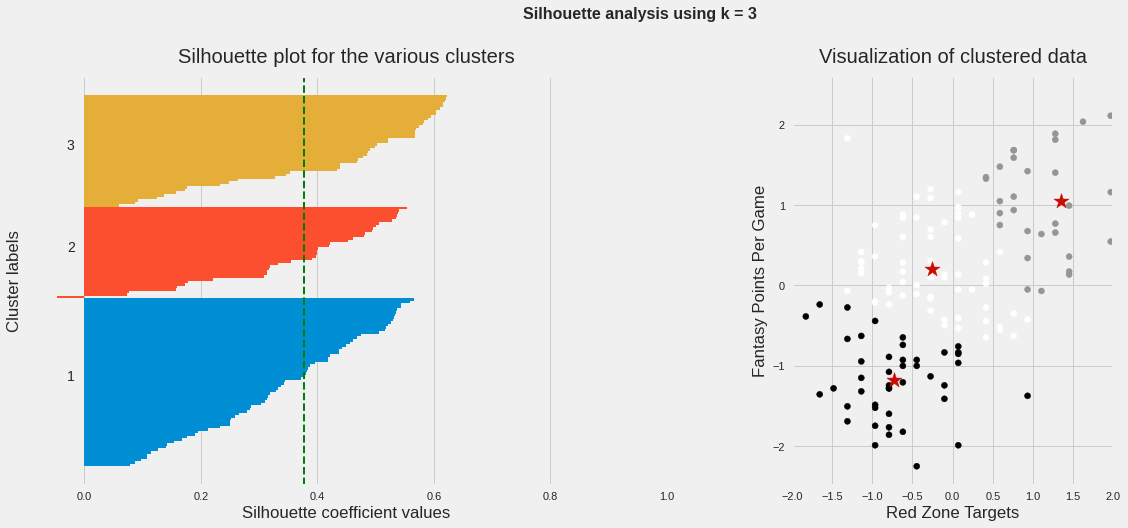

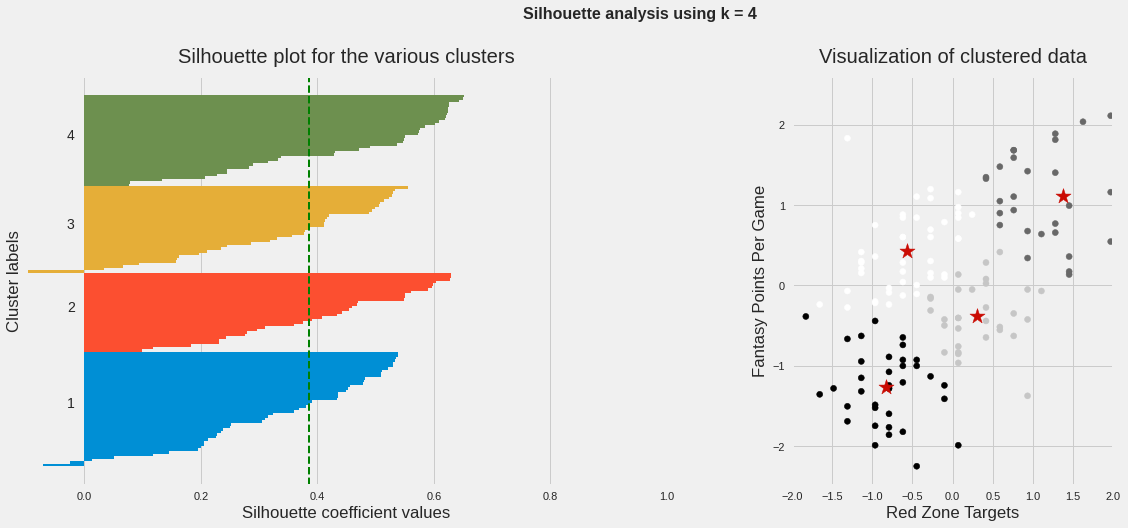

In [ ]:
for i, k in enumerate([2, 3, 4]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    labels = km.fit_predict(X_std)
    centroids = km.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X_std, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Scatter plot of data colored with labels
    ax2.scatter(X_std[:, 0], X_std[:, 1], c=labels)
    ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    ax2.set_xlim([-2, 2])
    ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Red Zone Targets')
    ax2.set_ylabel('Fantasy Points Per Game')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);

# KNN for missing values


In [ ]:
data1 = df2017_orig.drop(columns=['Name', 'Team','TargetAccuracy', 'Cushion', 'TrueCatchRate'])
data2 = df2018_orig.drop(columns=['Name', 'Team', 'TargetAccuracy', 'Cushion', 'TrueCatchRate'])
data3 = df2019_orig.drop(columns=['Name', 'Team', 'TargetAccuracy', 'Cushion', 'TrueCatchRate'])
print(data1.shape, data2.shape, data3.shape)

(225, 41) (237, 41) (237, 41)


In [ ]:
# summarize the number of rows with missing values for each column
for i in range(data1.shape[1]):
	# count number of rows with missing values
	n_miss = data1.iloc[i].isna().sum().sum()
	perc = n_miss / data1.shape[0] * 100
	print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 0 (0.0%)
> 6, Missing: 0 (0.0%)
> 7, Missing: 0 (0.0%)
> 8, Missing: 0 (0.0%)
> 9, Missing: 0 (0.0%)
> 10, Missing: 0 (0.0%)
> 11, Missing: 0 (0.0%)
> 12, Missing: 0 (0.0%)
> 13, Missing: 0 (0.0%)
> 14, Missing: 0 (0.0%)
> 15, Missing: 0 (0.0%)
> 16, Missing: 0 (0.0%)
> 17, Missing: 0 (0.0%)
> 18, Missing: 0 (0.0%)
> 19, Missing: 0 (0.0%)
> 20, Missing: 0 (0.0%)
> 21, Missing: 0 (0.0%)
> 22, Missing: 0 (0.0%)
> 23, Missing: 2 (0.9%)
> 24, Missing: 0 (0.0%)
> 25, Missing: 0 (0.0%)
> 26, Missing: 0 (0.0%)
> 27, Missing: 0 (0.0%)
> 28, Missing: 0 (0.0%)
> 29, Missing: 0 (0.0%)
> 30, Missing: 0 (0.0%)
> 31, Missing: 0 (0.0%)
> 32, Missing: 0 (0.0%)
> 33, Missing: 0 (0.0%)
> 34, Missing: 0 (0.0%)
> 35, Missing: 0 (0.0%)
> 36, Missing: 0 (0.0%)
> 37, Missing: 0 (0.0%)
> 38, Missing: 0 (0.0%)
> 39, Missing: 2 (0.9%)
> 40, Missing: 0 (0.0%)


In [ ]:
# summarize the number of rows with missing values for each column
for i in range(data2.shape[1]):
	# count number of rows with missing values
	n_miss = data2.iloc[i].isna().sum().sum()
	perc = n_miss / data2.shape[0] * 100
	print('> %d, Missing: %d (%.1f%%)' % (i, n_miss, perc))

> 0, Missing: 0 (0.0%)
> 1, Missing: 0 (0.0%)
> 2, Missing: 0 (0.0%)
> 3, Missing: 0 (0.0%)
> 4, Missing: 0 (0.0%)
> 5, Missing: 0 (0.0%)
> 6, Missing: 0 (0.0%)
> 7, Missing: 0 (0.0%)
> 8, Missing: 0 (0.0%)
> 9, Missing: 0 (0.0%)
> 10, Missing: 0 (0.0%)
> 11, Missing: 0 (0.0%)
> 12, Missing: 0 (0.0%)
> 13, Missing: 0 (0.0%)
> 14, Missing: 0 (0.0%)
> 15, Missing: 0 (0.0%)
> 16, Missing: 0 (0.0%)
> 17, Missing: 0 (0.0%)
> 18, Missing: 0 (0.0%)
> 19, Missing: 0 (0.0%)
> 20, Missing: 0 (0.0%)
> 21, Missing: 0 (0.0%)
> 22, Missing: 0 (0.0%)
> 23, Missing: 0 (0.0%)
> 24, Missing: 0 (0.0%)
> 25, Missing: 0 (0.0%)
> 26, Missing: 0 (0.0%)
> 27, Missing: 0 (0.0%)
> 28, Missing: 0 (0.0%)
> 29, Missing: 0 (0.0%)
> 30, Missing: 0 (0.0%)
> 31, Missing: 0 (0.0%)
> 32, Missing: 0 (0.0%)
> 33, Missing: 0 (0.0%)
> 34, Missing: 0 (0.0%)
> 35, Missing: 0 (0.0%)
> 36, Missing: 0 (0.0%)
> 37, Missing: 2 (0.8%)
> 38, Missing: 0 (0.0%)
> 39, Missing: 0 (0.0%)
> 40, Missing: 0 (0.0%)


In [ ]:
print('Total Missing: %d' % data2.isna().sum().sum())

Total Missing: 3228


In [ ]:
data1.iloc[23]

Rank                                   24.00
PlayerID                            11270.00
Played                                 16.00
ReceivingTargets                      132.00
Receptions                             69.00
ReceptionPercentage                    52.30
ReceivingYards                        838.00
ReceivingTouchdowns                     6.00
ReceivingLong                          50.00
ReceivingYardsPerTarget                 6.30
ReceivingYardsPerReception             12.10
RushingAttempts                         1.00
RushingYards                           -4.00
RushingYardsPerAttempt                 -4.00
RushingTouchdowns                       0.00
Fumbles                                 1.00
FumblesLost                             1.00
FantasyPointsPerGamePPR                11.60
FantasyPointsPPR                      186.40
HogRate                                15.30
SnapShare                              88.00
AverageTargetDistance                  12.10
AirYards  

KNNImputer with n_neighbors

In [ ]:
## KNNImputer to fill in missing values
from sklearn.impute import KNNImputer
# define imputer
imputer = KNNImputer(n_neighbors=25, weights='uniform', metric='nan_euclidean')
# fit on the dataset - data1, data2, data3
imputer.fit(data1)
# transform the dataset
data1_trans = imputer.transform(data1)
#print(data1_trans)
data1_trans = pd.DataFrame(data1_trans, columns = data1.columns) # convert to dataframe
print(data1_trans.head())
# print total missing
print('Total Missing before: %d' % data1.isna().sum().sum())
print('Total Missing after: %d' % data1_trans.isna().sum().sum())

imputer.fit(data2)
# transform the dataset
data2_trans = imputer.transform(data2)
data2_trans = pd.DataFrame(data2_trans, columns = data2.columns) # convert to dataframe
# print total missing
print('Total Missing before: %d' % data2.isna().sum().sum())
print('Total Missing after: %d' % data2_trans.isna().sum().sum())

#print(data3.head())
#imputer.fit(data3)
# transform the dataset
#data3_trans = imputer.transform(data3)
#print(data3_trans)
#data3_trans = pd.DataFrame(data3_trans, columns = data3.columns) # convert to dataframe
# print total missing
#print('Total Missing before: %d' % data3.isna().sum().sum())
#print('Total Missing after: %d' % data3_trans.isna().sum().sum())

   Rank  PlayerID  ...  FantasyPointsPPR_NextYear  FantasyPointsPerGamePPR_NextYear
0   1.0   11056.0  ...                     323.70                              21.6
1   2.0   14986.0  ...                     333.50                              20.8
2   3.0   15076.0  ...                     260.10                              16.3
3   4.0    5571.0  ...                     185.68                              11.6
4   5.0   16020.0  ...                     217.12                              13.6

[5 rows x 41 columns]
Total Missing before: 3116
Total Missing after: 0
Total Missing before: 3228
Total Missing after: 0


In [ ]:
print('before :', data1.shape, data2.shape)
print('after :', data1_trans.shape, data2_trans.shape)

before : (225, 41) (237, 41)
after : (225, 41) (237, 41)


In [ ]:
df1718 = pd.concat([df2017,df2018],ignore_index=True)
print('before :', df1718.shape)
df1718_trans = pd.concat([data1_trans,data2_trans],ignore_index=True)
print('after :', df1718_trans.shape)


before : (146, 39)
after : (462, 41)


## Feature Importance with Linear Regression

In [ ]:
df1718_trans.columns

Index(['Rank', 'PlayerID', 'Played', 'ReceivingTargets', 'Receptions',
       'ReceptionPercentage', 'ReceivingYards', 'ReceivingTouchdowns',
       'ReceivingLong', 'ReceivingYardsPerTarget',
       'ReceivingYardsPerReception', 'RushingAttempts', 'RushingYards',
       'RushingYardsPerAttempt', 'RushingTouchdowns', 'Fumbles', 'FumblesLost',
       'FantasyPointsPerGamePPR', 'FantasyPointsPPR', 'HogRate', 'SnapShare',
       'AverageTargetDistance', 'AirYards', 'AirYardsPerGame',
       'AirYardsPerReception', 'RedZoneTargets', 'EndzoneTargets',
       'TargetShare', 'FantasyPointsPerTarget', 'PlayerAgeExact',
       'TargetSeparation', 'ContestedTargets', 'ContestedCatches',
       'ContestedCatchConversionRate', 'YardsPerReception', 'YardsPerTarget',
       'YardsPerPassRoute', 'Drops', 'DropRate', 'FantasyPointsPPR_NextYear',
       'FantasyPointsPerGamePPR_NextYear'],
      dtype='object')

Feature: Rank, Score: -1.61234
Feature: Played, Score: -1.92106
Feature: ReceivingTargets, Score: 3.37025
Feature: Receptions, Score: 1.35178
Feature: ReceptionPercentage, Score: 0.56139
Feature: ReceivingYards, Score: 1.84984
Feature: ReceivingTouchdowns, Score: 1.60025
Feature: ReceivingLong, Score: 1.14839
Feature: ReceivingYardsPerTarget, Score: -1.13789
Feature: ReceivingYardsPerReception, Score: -0.31301
Feature: RushingAttempts, Score: 0.43510
Feature: RushingYards, Score: 1.11914
Feature: RushingYardsPerAttempt, Score: -0.53973
Feature: RushingTouchdowns, Score: -0.36146
Feature: Fumbles, Score: -1.22826
Feature: FumblesLost, Score: 1.02128
Feature: FantasyPointsPerGamePPR, Score: 3.61368
Feature: FantasyPointsPPR, Score: 1.78912
Feature: HogRate, Score: 0.86738
Feature: SnapShare, Score: 1.43791
Feature: AverageTargetDistance, Score: -0.12052
Feature: AirYards, Score: -0.32264
Feature: AirYardsPerGame, Score: 0.97128
Feature: AirYardsPerReception, Score: 0.19631
Feature: RedZo

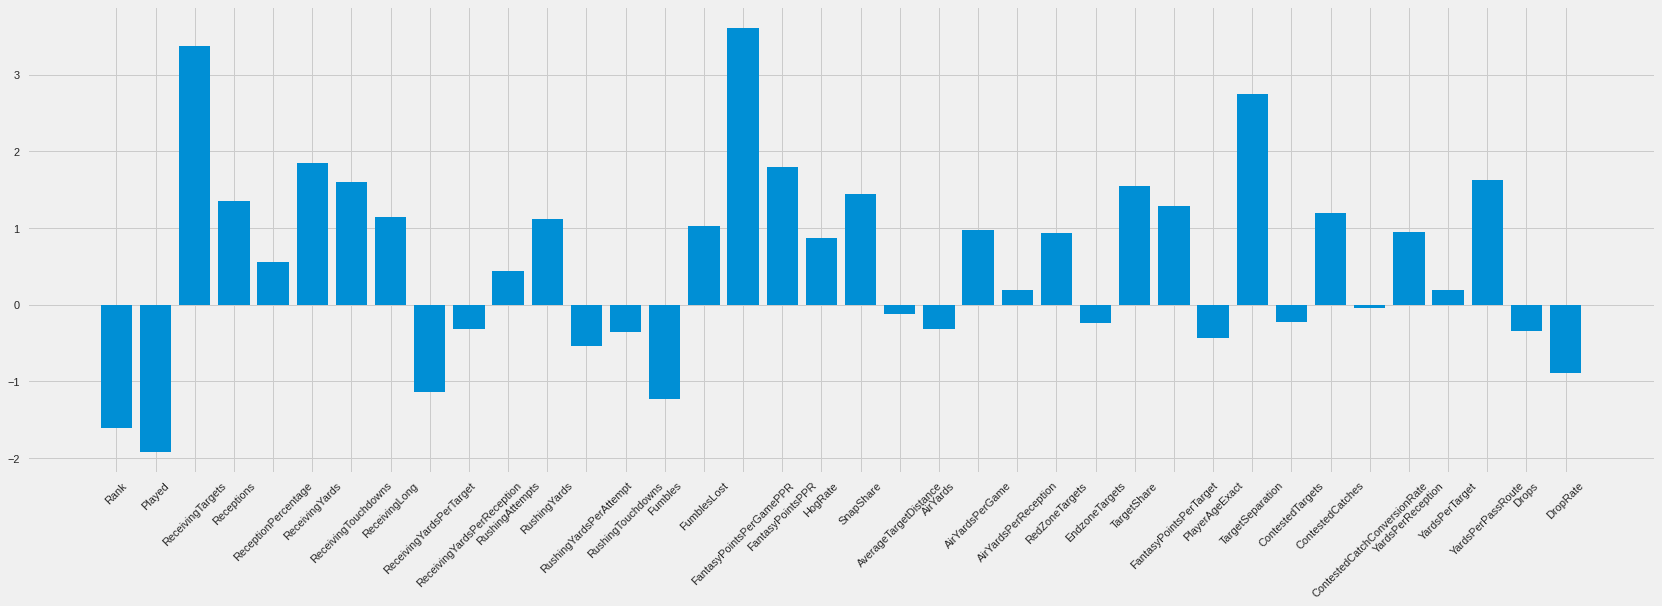

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

#Non normalized training set
# train_x_1 = df1718_trans.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID"])
# train_y_1 = df1718_trans["FantasyPointsPerGamePPR_NextYear"]

#Normalized training set
train_x_2 = normalizeDF(df1718_trans.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID"]))
train_y_2 = df1718_trans["FantasyPointsPerGamePPR_NextYear"]

# define the model
model = BayesianRidge()
# fit the model
# model.fit(train_x_1, train_y_1)
model.fit(train_x_2, train_y_2)

# get importance
importance = model.coef_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0s, Score: %.5f' % (train_x_2.columns[i],v))
# plot feature importance
#plt.bar([x for x in range(len(importance))], importance)
plt.figure(figsize=(26,8))
plt.xticks(rotation=45)
plt.bar([x for x in train_x_2.columns], importance)
plt.show()

# PCA and SVM in a pipeline
https://towardsdatascience.com/visualizing-support-vector-machine-decision-boundary-69e7591dacea

In [ ]:
df1718_trans.head()

,Rank,PlayerID,Played,ReceivingTargets,Receptions,ReceptionPercentage,ReceivingYards,ReceivingTouchdowns,ReceivingLong,ReceivingYardsPerTarget,ReceivingYardsPerReception,RushingAttempts,RushingYards,RushingYardsPerAttempt,RushingTouchdowns,Fumbles,FumblesLost,FantasyPointsPerGamePPR,FantasyPointsPPR,HogRate,SnapShare,AverageTargetDistance,AirYards,AirYardsPerGame,AirYardsPerReception,RedZoneTargets,EndzoneTargets,TargetShare,FantasyPointsPerTarget,PlayerAgeExact,TargetSeparation,ContestedTargets,ContestedCatches,ContestedCatchConversionRate,YardsPerReception,YardsPerTarget,YardsPerPassRoute,Drops,DropRate,FantasyPointsPPR_NextYear,FantasyPointsPerGamePPR_NextYear
0,1.0,11056.0,14.0,163.0,101.0,62.0,1533.0,9.0,57.0,9.4,15.2,0.0,0.0,0.0,0.0,4.0,0.0,22.2,310.30,19.3,92.0,13.7,1103.0,78.8,10.9,21.0,14.0,30.7,1.90,33.0,1.67,31.0,20.0,64.5,15.2,9.5,2.98,5.0,3.1,323.70,21.6
1,2.0,14986.0,15.0,174.0,96.0,55.2,1378.0,13.0,72.0,7.9,14.4,0.0,0.0,0.0,0.0,1.0,1.0,20.7,309.80,18.1,100.0,13.7,1101.0,73.4,11.5,19.0,24.0,35.2,1.79,29.1,0.96,52.0,23.0,44.2,14.4,7.9,2.54,6.0,3.4,333.50,20.8
2,3.0,15076.0,16.0,159.0,102.0,64.2,1393.0,6.0,51.0,8.8,13.7,2.0,9.0,4.5,1.0,1.0,0.0,17.8,284.20,19.9,79.9,9.4,906.0,56.6,8.9,24.0,14.0,27.7,1.79,29.2,1.39,24.0,10.0,41.7,13.7,8.8,2.77,12.0,7.5,260.10,16.3
3,4.0,5571.0,16.0,161.0,109.0,67.7,1156.0,6.0,37.0,7.2,10.6,0.0,0.0,0.0,0.0,1.0,1.0,16.3,261.44,15.9,100.0,8.7,771.0,48.2,7.1,20.0,7.0,27.2,1.62,37.9,1.52,22.0,13.0,59.1,10.6,7.2,1.87,4.0,2.5,185.68,11.6
4,5.0,16020.0,16.0,161.0,112.0,69.6,987.0,9.0,49.0,6.1,8.8,1.0,-7.0,-7.0,0.0,4.0,2.0,16.2,260.00,17.8,93.8,6.2,502.0,31.4,4.5,23.0,9.0,27.4,1.63,28.6,1.42,23.0,9.0,39.1,8.8,6.1,1.70,8.0,5.0,217.12,13.6


In [ ]:
print('Shape of dataframe (before): ', df1718.shape)
print('Shape of dataframe (after): ', df1718_trans.shape)

Shape of dataframe (before):  (146, 39)
Shape of dataframe (after):  (462, 41)


Create two tiers for the players - tier 1 and tier 2

In [ ]:
# create a list of our conditions
conditions = [
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] <= 10),
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] > 10)
    ]

# create a list of the values we want to assign for each condition
values = ['tier_2', 'tier_1']

# create a new column and use np.select to assign values to it using our lists as arguments
df1718_trans['tier'] = np.select(conditions, values)

Create 5 tiers

In [ ]:
# create a list of our conditions
conditions = [
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] <= 7),
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] > 7) & (df1718_trans['FantasyPointsPerGamePPR_NextYear'] <= 11),
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] > 11) & (df1718_trans['FantasyPointsPerGamePPR_NextYear'] <=15),
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] > 15) & (df1718_trans['FantasyPointsPerGamePPR_NextYear'] <=19),
    (df1718_trans['FantasyPointsPerGamePPR_NextYear'] > 19)
    ]

# create a list of the values we want to assign for each condition
values = ['tier_5', 'tier_4', 'tier_3', 'tier_2', 'tier_1']

# create a new column and use np.select to assign values to it using our lists as arguments
df1718_trans['tier'] = np.select(conditions, values)

In [ ]:
print(df1718_trans.columns)
data = df1718_trans.drop(columns=["Rank", "FantasyPointsPPR_NextYear", "FantasyPointsPerGamePPR_NextYear", "PlayerID", "tier"])
target = df1718_trans[["tier"]]

print(data.head())
print(target.head())

df1718_trans['tier'].value_counts().plot(kind='bar')

Index(['Rank', 'PlayerID', 'Played', 'ReceivingTargets', 'Receptions',
       'ReceptionPercentage', 'ReceivingYards', 'ReceivingTouchdowns',
       'ReceivingLong', 'ReceivingYardsPerTarget',
       'ReceivingYardsPerReception', 'RushingAttempts', 'RushingYards',
       'RushingYardsPerAttempt', 'RushingTouchdowns', 'Fumbles', 'FumblesLost',
       'FantasyPointsPerGamePPR', 'FantasyPointsPPR', 'HogRate', 'SnapShare',
       'AverageTargetDistance', 'AirYards', 'AirYardsPerGame',
       'AirYardsPerReception', 'RedZoneTargets', 'EndzoneTargets',
       'TargetShare', 'FantasyPointsPerTarget', 'PlayerAgeExact',
       'TargetSeparation', 'ContestedTargets', 'ContestedCatches',
       'ContestedCatchConversionRate', 'YardsPerReception', 'YardsPerTarget',
       'YardsPerPassRoute', 'Drops', 'DropRate', 'FantasyPointsPPR_NextYear',
       'FantasyPointsPerGamePPR_NextYear'],
      dtype='object')


KeyError: ignored

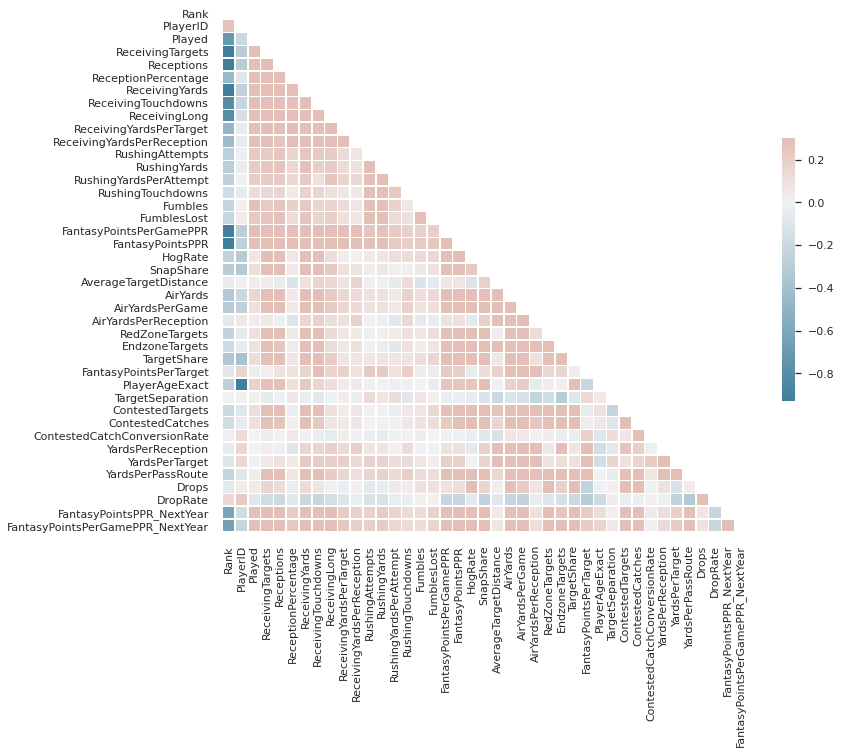

In [ ]:
# correlation matrix
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")


# Compute the correlation matrix
corr = df1718_trans.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
# split data into train and test
from sklearn.model_selection import train_test_split
_data_ = df1718_trans.drop(columns=["Rank", "FantasyPointsPPR_NextYear", "FantasyPointsPerGamePPR_NextYear", "PlayerID"])
X_train, X_test, Y_train, Y_test = train_test_split(_data_,df1718_trans["FantasyPointsPerGamePPR_NextYear"],test_size=0.25,random_state=30)
print("train feature shape: ", X_train.shape)
print("test feature shape: ", X_test.shape)

train feature shape:  (346, 37)
test feature shape:  (116, 37)


In [ ]:
# for PCA, first scale the data
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler1 = StandardScaler()
scaler1.fit(_data_)
feature_scaled = scaler1.transform(_data_)

# apply PCA
pca1 = PCA(n_components=4)
pca1.fit(feature_scaled)
feature_scaled_pca = pca1.transform(feature_scaled)
print("Shape of the scaled and PCA'ed features: ", np.shape(feature_scaled_pca))


Shape of the scaled and PCA'ed features:  (462, 4)


In [ ]:
# variance of 4 components
feat_var = np.var(feature_scaled_pca,axis=0)
feat_var_rat = feat_var/(np.sum(feat_var))
print("Variance Ratio of the 4 Principal Components Analysis: ", feat_var_rat)

Variance Ratio of the 4 Principal Components Analysis:  [0.50142955 0.21789079 0.16505049 0.11562917]


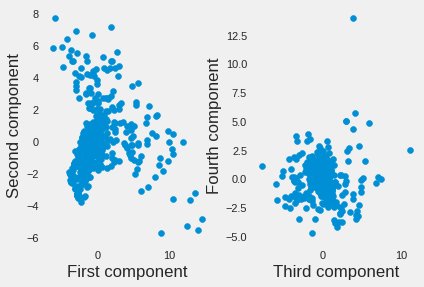

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

plt.subplot(1,2,1)
plt.scatter(feature_scaled_pca[:,0], feature_scaled_pca[:,1])
plt.xlabel('First component')
plt.ylabel('Second component')
plt.grid()
plt.subplot(1,2,2)
plt.xlabel('Third component')
plt.ylabel('Fourth component')
plt.scatter(feature_scaled_pca[:,2], feature_scaled_pca[:,3])
plt.grid()

plt.show()

In [ ]:
#Y_test = Y_test.replace('tier_1', 1.0)
#Y_test = Y_test.replace('tier_2', 2.0)
#Y_test = Y_test.replace('tier_3', 3.0)
#Y_test = Y_test.replace('tier_4', 4.0)
#Y_test = Y_test.replace('tier_5', 5.0)
Y_test.head()

,tier
128,tier_5
451,tier_5
124,tier_5
231,tier_3
307,tier_5


## 2D Decision Boundary

In [ ]:
# Pipeline steps for standard scaler, PCA and SVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe_steps = [('scaler', StandardScaler()), ('pca', PCA()), ('SupVM', SVC(kernel='linear'))]

check_params={
    'pca__n_components': [2],
    'SupVM__C': [0.1, 0.5, 1, 10, 30, 40, 50, 75, 100, 500, 1000],
    'SupVM__gamma' : [ 0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.5, 1, 5, 10, 10, 50]
}

pipeline = Pipeline(pipe_steps)

### Important: This takes some time to run. 
Keep tier category as strings 'tier_1', 'tier_2' etc.

In [ ]:
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

print("Start fitting training data")
for cv in tqdm(range(4,6)):
  create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
  create_grid.fit(X_train, Y_train)
  print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, Y_test)))
  print("****** Best-Fit Parameters for training data ******")
  print(create_grid.best_params_)

print("DONE")

Start fitting training data


KeyboardInterrupt: ignored

In [ ]:
def plot_contours(ax, clf, xx, yy, **params):
  Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  out = ax.contourf(xx, yy, Z, **params)
  return out

def make_meshgrid(x, y, h=.2):
  x_min, x_max = x.min() - 1, x.max() + 1
  y_min, y_max = y.min() - 1, y.max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  return xx, yy

def flatten_to_strings(listOfLists):
    """Flatten a list of (lists of (lists of strings)) for any level 
    of nesting"""
    result = []

    for i in listOfLists:
        # Only append if i is a basestring (superclass of string)
        if isinstance(i, str):
            result.append(i)
        # Otherwise call this function recursively
        else:
            result.extend(flatten_to_strings(i))
    return result




# Bayesian Ridge Results For Feature Selection

In [ ]:
#Normalized training set
train_x_2 = normalizeDF(df1718.drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"]))
train_y_2 = df1718["FantasyPointsPerGamePPR_NextYear"]

#Create the testing set, which is sorted by playerID containing the same elements as expert_prediction, in order 
#Testing data sorted by playerID (actual data does not contain the playerID, though)
test_x_1 = df2019.sort_values(by=["PlayerID"]).drop(columns=["FantasyPointsPerGamePPR_NextYear","FantasyPointsPPR_NextYear","PlayerID", "ScoreTier_NextYear"])
test_x_2 = normalizeDF(test_x_1)
test_y = df2019.sort_values(by=["PlayerID"])["FantasyPointsPerGamePPR_NextYear"]

test_x_1.reset_index(inplace=True, drop=True)
test_x_2.reset_index(inplace=True, drop=True)
test_y.reset_index(inplace=True, drop=True)


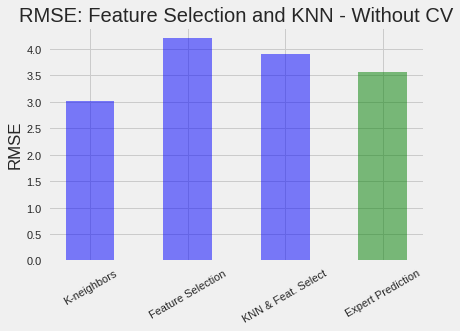

RMSE - K-neighbors:		 3.01
RMSE - Feature Selection:	 4.20
RMSE - KNN & Feat. Select:	 3.91
RMSE - Expert Prediction:	 3.56


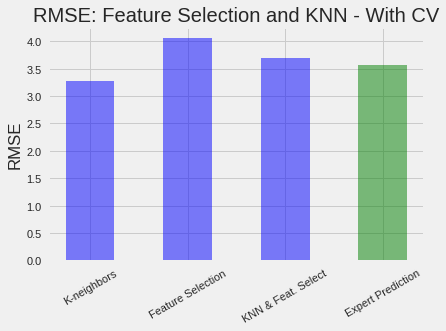

RMSE - K-neighbors:		 3.28
RMSE - Feature Selection:	 4.05
RMSE - KNN & Feat. Select:	 3.69
RMSE - Expert Prediction:	 3.56


Change in RMSE by applying CV:
RMSE Change - K-neighbors:		 0.27
RMSE Change - Feature Selection:	 -0.15
RMSE Change - KNN & Feat. Select:	 -0.22


In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(df1718_trans.drop(columns=["Rank", "FantasyPointsPPR_NextYear", "FantasyPointsPerGamePPR_NextYear", "PlayerID"]),df1718_trans['FantasyPointsPerGamePPR_NextYear'],test_size=0.25,random_state=30)

scaler1 = StandardScaler()
model = BayesianRidge()
pca1 = PCA(n_components=4)

#X_train_ = X_train_.drop(columns=['tier'])
#X_test_ = X_test_.drop(columns=['tier'])
scaler1.fit(X_test_)
X_test_scaled = scaler1.transform(X_test_)
scaler1.fit(X_test_)
X_train_scaled = scaler1.transform(X_train_)

#only KNN

x_u = np.concatenate([X_train_scaled, X_test_scaled])
y_u = pd.concat([Y_train_, Y_test_])
model.fit(X_train_scaled, Y_train_)
feat_selection_prediction = model.predict(X_test_scaled)
feat_selection_prediction_rmse_noFS = np.sqrt(np.mean((feat_selection_prediction-Y_test_)**2))
model_cv = cross_validate(model, x_u, y_u, cv = 5, scoring = ('r2', 'neg_root_mean_squared_error'))
model_cv_rmse_noFS = -1*model_cv['test_neg_root_mean_squared_error'].mean()

#pca and KNN
X_test_scaled_reduced = pca1.fit_transform(X_test_scaled)
X_train_scaled_reduced = pca1.fit_transform(X_train_scaled)
x_u = np.concatenate([X_train_scaled_reduced, X_test_scaled_reduced])
y_u = pd.concat([Y_train_, Y_test_])
model.fit(X_train_scaled_reduced, Y_train_)
feat_selection_prediction = model.predict(X_test_scaled_reduced)
feat_selection_prediction_rmse = np.sqrt(np.mean((feat_selection_prediction-Y_test_)**2))
model_cv = cross_validate(model, x_u, y_u, cv = 5, scoring = ('r2', 'neg_root_mean_squared_error'))
model_cv_rmse = -1*model_cv['test_neg_root_mean_squared_error'].mean()


#only pca
X_test_scaled_reduced = pca1.fit_transform(test_x_2)
X_train_scaled_reduced = pca1.fit_transform(train_x_2)
x_u = np.concatenate([X_train_scaled_reduced, X_test_scaled_reduced])
y_u = pd.concat([train_y_2, test_y])
model.fit(X_train_scaled_reduced, train_y_2)
feat_selection_prediction = model.predict(X_test_scaled_reduced)
feat_selection_prediction_rmse_noK = np.sqrt(np.mean((feat_selection_prediction-test_y)**2))
model_cv = cross_validate(model, x_u, y_u, cv = 5, scoring = ('r2', 'neg_root_mean_squared_error'))
model_cv_rmse_noK = -1*model_cv['test_neg_root_mean_squared_error'].mean()


#no cv rmse
plt.bar([0, 1, 2, 3], [feat_selection_prediction_rmse_noFS, feat_selection_prediction_rmse_noK, feat_selection_prediction_rmse, expert_rmse_cache], align='center', alpha=0.5, width = 0.5, color=['blue', 'blue', 'blue', 'green'])
plt.xticks([0, 1, 2, 3], ["K-neighbors", "Feature Selection", "KNN & Feat. Select", "Expert Prediction"], rotation = 30)
plt.ylabel('RMSE')
plt.title('RMSE: Feature Selection and KNN - Without CV')
plt.show()


print('RMSE - K-neighbors:\t\t', f'{feat_selection_prediction_rmse_noFS:,.2f}')
print('RMSE - Feature Selection:\t', f'{feat_selection_prediction_rmse_noK:,.2f}')
print('RMSE - KNN & Feat. Select:\t', f'{feat_selection_prediction_rmse:,.2f}')
print('RMSE - Expert Prediction:\t', f'{expert_rmse_cache:,.2f}')


#cv rmse
plt.bar([0, 1, 2, 3], [model_cv_rmse_noFS, model_cv_rmse_noK, model_cv_rmse, expert_rmse_cache], align='center', alpha=0.5, width = 0.5, color=['blue', 'blue', 'blue', 'green'])
plt.xticks([0, 1, 2, 3], ["K-neighbors", "Feature Selection", "KNN & Feat. Select", "Expert Prediction"], rotation = 30)
plt.ylabel('RMSE')
plt.title('RMSE: Feature Selection and KNN - With CV')
plt.show()

print('RMSE - K-neighbors:\t\t', f'{model_cv_rmse_noFS:,.2f}')
print('RMSE - Feature Selection:\t', f'{model_cv_rmse_noK:,.2f}')
print('RMSE - KNN & Feat. Select:\t', f'{model_cv_rmse:,.2f}')
print('RMSE - Expert Prediction:\t', f'{expert_rmse_cache:,.2f}')

print('\n\nChange in RMSE by applying CV:')
print('RMSE Change - K-neighbors:\t\t', f'{model_cv_rmse_noFS - feat_selection_prediction_rmse_noFS:,.2f}')
print('RMSE Change - Feature Selection:\t', f'{model_cv_rmse_noK - feat_selection_prediction_rmse_noK:,.2f}')
print('RMSE Change - KNN & Feat. Select:\t', f'{model_cv_rmse - feat_selection_prediction_rmse:,.2f}')




In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
scaler1 = StandardScaler()
scaler1.fit(X_test)
X_test_scaled = scaler1.transform(X_test)

pca1 = PCA(n_components=2)
X_test_scaled_reduced = pca1.fit_transform(X_test_scaled)

svm_model = SVC(kernel='rbf', C=float(create_grid.best_params_['SupVM__C']), gamma=float(create_grid.best_params_['SupVM__gamma']))

classify = svm_model.fit(X_test_scaled_reduced, Y_test)

AttributeError: ignored

NameError: ignored

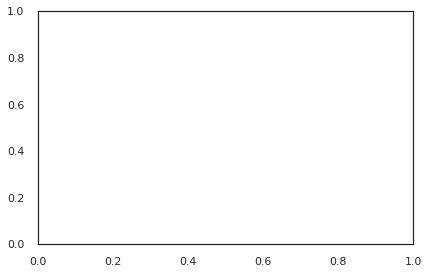

In [ ]:
# Set-up grid for plotting.
X0, X1 = X_test_scaled_reduced[:, 0], X_test_scaled_reduced[:, 1]
#print(X0, X1)
xx, yy = make_meshgrid(X0, X1)

fig, ax = plt.subplots()
# title for the plots
title = ('Decision surface of SVC ')

## change tiers to floats for plotting
Y_test = Y_test.replace('tier_1', 1.0)
Y_test = Y_test.replace('tier_2', 2.0)

plot_contours(ax, classify, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y_test['tier'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_ylabel('2nd Principal Component')
ax.set_xlabel('1st Principal Component')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title(title)
ax.legend()
plt.show()

# Different SVM Classifiers
https://scikit-learn.org/0.18/auto_examples/svm/plot_iris.html

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with
# use training data to decompose to 2 pca components
scaler1 = StandardScaler()
scaler1.fit(X_train)
X_train_scaled = scaler1.transform(X_train)

pca1 = PCA(n_components=2)
X_train_scaled_reduced = pca1.fit_transform(X_train_scaled)

X = X_train_scaled_reduced 

## Need to convert strings to float
Y_train_float = Y_train.replace('tier_1', int(1))
Y_train_float = Y_train_float.replace('tier_2', int(2))
y_float = Y_train_float['tier']
#print(y_float.head())
y = Y_train['tier']

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors
C = 1.0  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y_float)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y_float)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y_float)
lin_svc = svm.LinearSVC(C=C).fit(X, y_float)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    #print(Z)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y_float, cmap=plt.cm.coolwarm)
    plt.xlabel('1st Principal Component')
    plt.ylabel('2nd Principal Component')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()